### Start importing all libraries

In [18]:
# Global
import numpy as np

# Local
import examples_utils as eu
import fastPTA.utils as ut
import fastPTA.plotting_functions as pf
from fastPTA.Fisher_code import compute_fisher
from fastPTA.MCMC_code import run_MCMC

### Constants to be used in the analysis

In [17]:
# Total observation time in years
T_obs_yrs = 16.03

# Number of frequencies used in the analysis
n_frequencies = 30

# Number of pulsars in the analysis
n_pulsars = 25

# Specify the type of noise to be used in the analysis
which_experiment = eu.EPTAlike

# Set the label to specify the signal model
signal_label = "power_law"

# The analysis assumes a power law template, specify here the input parameters
log_amplitude = -7.1995  # log amplitude
tilt = 2.0  # Tilt

# Specify the true signal parameters
signal_parameters = np.array([log_amplitude, tilt])

# Specify the labels for the signal parameters
parameter_labels = [r"$\alpha_{\rm PL}$", r"$n_{\rm T}$"]

# Specify the priors for the signal parameters (should be a 2D array with the columns running over the parameters)
priors = []

# Number of points to generate for the Fisher
len_fisher_data = int(1e4)

### Some inputs for the MCMC

In [19]:
# Whether the MCMC should be rerun
rerun_MCMC = True

# Whether the MCMC data should be regenerated
regenerate_MCMC_data = True

# Whether to generate a data realization or take data at face value
realization = False

# Number of burnin steps for the MCMC
burnin_steps_default = 300

# Maximum number of iterations to get R close to 1
i_max_default = 100

# Accepted value for the Gellman-Rubin convergence criterion
R_convergence_default = 1e-1

# Criterion to be used for the convergence of the MCMC chains
R_criterion_default = "mean_squared"

# Number of MCMC steps in each iteration
MCMC_iteration_steps_default = 500

# Path to the MCCM_data
path_to_MCMC_data = "generated_data/MCMC_data.npz"

# Path to the MCMC chains
path_to_MCMC_chains = "generated_chains/MCMC_chains.npz"

### Set the inputs for the Fisher and MCMC analysis

In [22]:
# Dictionary with the kwargs to generete the pulsar catalogs
generate_catalog_kwargs = {
    "n_pulsars": n_pulsars,
    "save_catalog": False,
    **which_experiment,
}

# Dictionary with the kwargs to generate noise and orf tensors
get_tensors_kwargs = {
    "add_curn": False,
    "regenerate_catalog": True,
}

# Dictionary with the kwargs for the Fisher matrix
fisher_kwargs = {
    "T_obs_yrs": T_obs_yrs,
    "n_frequencies": n_frequencies,
    "signal_label": signal_label,
    "signal_parameters": signal_parameters,
}

# Dictionary with the kwargs for the MCMC
MCMC_kwargs = {
    "regenerate_MCMC_data": regenerate_MCMC_data,
    "realization": realization,
    "path_to_MCMC_data": path_to_MCMC_data,
    "path_to_MCMC_chains": path_to_MCMC_chains,
    "i_max": i_max_default,
    "R_convergence": R_convergence_default,
    "R_criterion": R_criterion_default,
    "burnin_steps": burnin_steps_default,
    "MCMC_iteration_steps": MCMC_iteration_steps_default,
}

### Prepare the model to scan over

In [24]:
if "regenerate_catalog" in get_tensors_kwargs.keys():
    if get_tensors_kwargs["regenerate_catalog"]:
        rerun_MCMC = True

(
    frequency,
    signal,
    HD_functions_IJ,
    HD_coeffs,
    effective_noise,
    SNR,
    fisher,
) = compute_fisher(
    **fisher_kwargs,
    get_tensors_kwargs=get_tensors_kwargs,
    generate_catalog_kwargs=generate_catalog_kwargs,
)

covariance = ut.compute_inverse(fisher)
fisher_data = np.random.multivariate_normal(
    signal_parameters, covariance, size=len_fisher_data
)
errors = np.sqrt(np.diag(covariance))
print("Fisher errors", errors)

fisher_ranges = np.vstack(
    (signal_parameters - 5 * errors, signal_parameters + 5 * errors)
)

get_tensors_kwargs["regenerate_catalog"] = False

Fisher errors [0.23784615 0.31128867]


In [27]:
try:
    if rerun_MCMC:
        raise FileNotFoundError("Flag forces MCMC chains regeneration")

    MCMC_results = np.load(path_to_MCMC_chains)
    MCMC_data = MCMC_results["samples"]
    pdfs = MCMC_results["pdfs"]

except FileNotFoundError:

    print("Entered")

    if not np.any(priors):
        priors = np.array(fisher_ranges)
        print(priors)

    MCMC_data, pdfs = run_MCMC(
        priors,
        **fisher_kwargs,
        **MCMC_kwargs,
        get_tensors_kwargs=get_tensors_kwargs,
    )

Entered

Regenerating MCMC data
- Will generate a data realization

Initial run


  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:02<00:00, 133.60it/s]


Burn-in dropped, here starts the proper run


100%|██████████| 500/500 [00:03<00:00, 142.63it/s]


At this step R = 1.1598


100%|██████████| 500/500 [00:03<00:00, 140.62it/s]

At this step R = 1.0676
This took 9.3 seconds 

Storing as generated_chains/MCMC_chains.npz


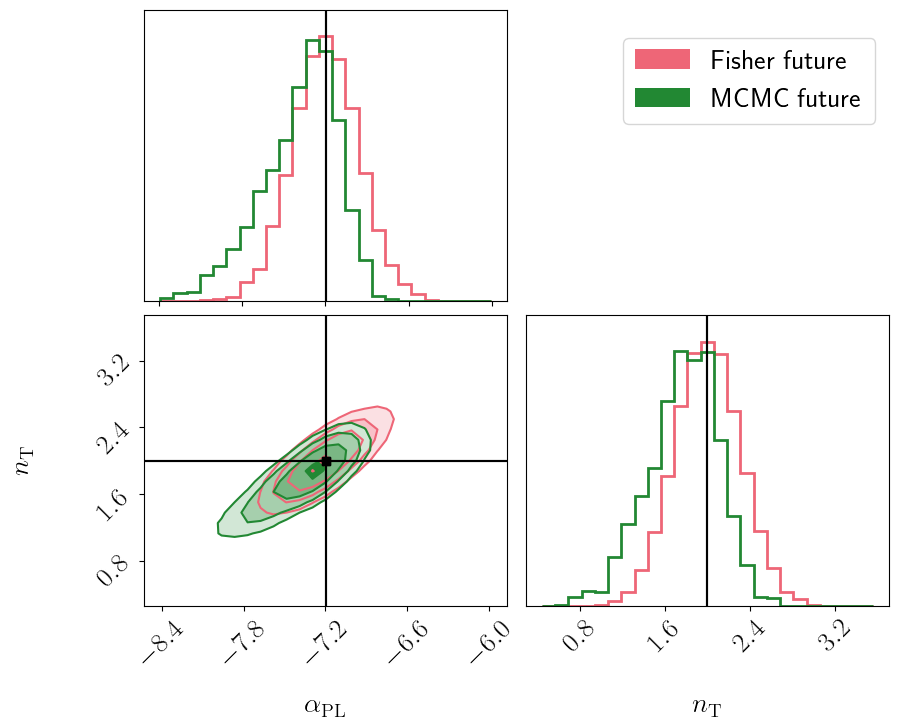

In [28]:
# This part should be moved out of this function
datasets = [fisher_data, MCMC_data]
weights = [
    np.ones(len_fisher_data),
    np.ones(MCMC_data.shape[0]),  # type: ignore
]
smooth = [1.0, 1.0]
ranges = np.array(fisher_ranges.T)

pf.plot_corner(
    datasets,
    colors=[pf.my_colormap["red"], pf.my_colormap["green"]],
    truths=signal_parameters,
    chain_labels=["Fisher future", "MCMC future"],
    weights=weights,
    smooth=smooth,
    labels=parameter_labels,
    range=ranges,
    truth_color="black",
)